<center><h1>Central Difference Schemes</h1></center>

<center>Marin Lauber, 2019</center>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from scipy import sparse
try:
    plt.style.use("jupyter")
except OSError:
    print("Using default ploting style")

The prototype central difference schemes for a function $\phi$ can be written as

$$
    \frac{\partial\phi}{\partial x} = \frac{-\epsilon\phi_{i+4} + \gamma\phi_{i+3} - \beta\phi_{i+2} + \alpha\phi_{i+1} - \alpha\phi_{i-1} + \beta\phi_{i-2} - \gamma\phi_{i-3} + \epsilon\phi_{i-4}}{\Delta x} + \mathcal{O}(...)
$$

where the coefficients are set based on the desired order of the method

| Order | $\epsilon$ | $\gamma$ | $\beta$ | $\alpha$ |
| --- |---|---|---|---|
| 2$^{nd}$ | 0 | 0 | 0  | $\frac{1}{2}$  |
| 4$^{th}$ | 0 | 0 | $\frac{1}{12}$   | $\frac{2}{3}$  |
| 6$^{th}$ | 0 | $\frac{1}{60}$   | $\frac{3}{20}$   | $\frac{3}{4}$  |
| 8$^{th}$ | $\frac{1}{280}$   |  $\frac{4}{105}$  |  $\frac{1}{5}$  | $\frac{4}{5}$  |

In [3]:
def CDS(a, dx, order=2):
    
    """
    Takes the first derivative of a discrete periodic field a
    using n-order central difference scheme
    """
    
    # standard scheme CDS-2
    alpha   = 1./(2.*dx)
    beta    = 0.
    gamma   = 0.
    epsilon = 0.
    
    # adjust coeffs for other schemes
    if order==4:
        alpha   = 2./(3.*dx)
        beta    = 1./(12.*dx)
        gamma   = 0.
        epsilon = 0.
    elif order==6:
        alpha   = 3./(4.*dx)
        beta    = 3./(20.*dx)
        gamma   = 1./(60.*dx)
        epsilon = 0.
    elif order==8:
        alpha   = 4./(5.*dx)
        beta    = 1./(5.*dx)
        gamma   = 4./(105.*dx)
        epsilon = 1./(280.*dx)

    # storage array
    xd2 = np.empty_like(a)
    
    # interior points
    xd2[4:-4] = alpha*(a[5:-3] - a[3:-5]) +    beta*(a[2:-6] - a[6:-2]) +\
                gamma*(a[7:-1] - a[1:-7]) + epsilon*(a[ :-8] - a[8:  ])
    
    # boundary points
    xd2[-4] = alpha*(a[-3] - a[-5]) +    beta*(a[-6] - a[-2]) +\
              gamma*(a[-1] - a[-7]) + epsilon*(a[-8] - a[ 0])
    xd2[-3] = alpha*(a[-2] - a[-4]) +    beta*(a[-5] - a[-1]) +\
              gamma*(a[ 0] - a[-6]) + epsilon*(a[-7] - a[ 1])
    xd2[-2] = alpha*(a[-1] - a[-3]) +    beta*(a[-4] - a[ 0]) +\
              gamma*(a[ 1] - a[-5]) + epsilon*(a[-6] - a[ 2])
    xd2[-1] = alpha*(a[ 0] - a[-2]) +    beta*(a[-3] - a[ 1]) +\
              gamma*(a[ 2] - a[-4]) + epsilon*(a[-5] - a[ 3])
    xd2[ 0] = alpha*(a[ 1] - a[-1]) +    beta*(a[-2] - a[ 2]) +\
              gamma*(a[ 3] - a[-3]) + epsilon*(a[-4] - a[ 4])
    xd2[ 1] = alpha*(a[ 2] - a[ 0]) +    beta*(a[-1] - a[ 3]) +\
              gamma*(a[ 4] - a[-2]) + epsilon*(a[-3] - a[ 5])
    xd2[ 2] = alpha*(a[ 3] - a[ 1]) +    beta*(a[ 0] - a[ 4]) +\
              gamma*(a[ 5] - a[-1]) + epsilon*(a[-2] - a[ 6])
    xd2[ 3] = alpha*(a[ 4] - a[ 2]) +    beta*(a[ 1] - a[ 5]) +\
              gamma*(a[ 6] - a[ 0]) + epsilon*(a[-1] - a[ 7])
    
    return xd2

In [4]:
x, dx = np.linspace(0, 2*np.pi, 1000, endpoint=False, retstep=True)
f = np.cos(x)
df = -np.sin(x)
for order in [2, 4, 6, 8]:
    print(np.allclose(CDS(f, dx, order), df))

True
True
True
True


## Order of accuracy

---

The Gaussian profile with a mean $\nu$ and a variance $\sigma^2$ is defined as

\begin{equation}
    \mathcal{N}(x | \nu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}e^{\frac{-(x-\nu)^2}{2\sigma^2}}.
\end{equation}

In [5]:
def Gaussian(x, v=3., sigma=1.):
    return np.exp(-(x - v)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi)* sigma)

\begin{equation}
    \frac{d}{dx}\mathcal{N}(x | \nu, \sigma^2) = \frac{-(x-\nu)^2}{\sigma^3\sqrt{2\pi}}e^{\frac{-(x-\nu)^2}{2\sigma^2}}.
\end{equation}

In [6]:
def GaussianDer(x, v=3., sigma=1.):
    return -(x - v) * np.exp(-(x - v)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma**3)

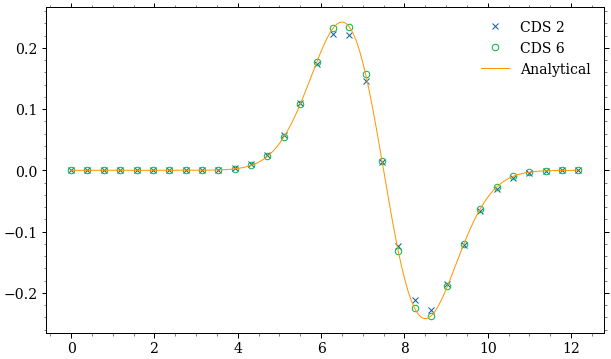

In [7]:
x, dx = np.linspace(0, 4*np.pi, 32, endpoint=False, retstep=True)
f = Gaussian(x,sigma=1.,v=7.5)
plt.plot(x, CDS(f, dx, 2), 'x', markevery=1, label="CDS 2")
plt.plot(x, CDS(f, dx, 6), 'o', mfc="None", markevery=1, label="CDS 6")
x_sol = np.linspace(np.min(x), np.max(x), 1000, endpoint=False)
plt.plot(x_sol, GaussianDer(x_sol, v=7.5, sigma=1.), label="Analytical")
plt.legend();

We can test the different schemes on this function and asses the error of each of them. We use the $L_{\infty}$ norm of the error

$$
    L_{\infty} = \max(|\phi - \phi_e|)
$$

In [8]:
norm = np.ones((5, 4))
orders = np.array([2, 4, 6, 8])
resolutions = np.array([32,64,128,256])
for i, order in enumerate(orders):
    for j, res in enumerate(resolutions):
        x, dx = np.linspace(0, 4*np.pi, res, endpoint=False, retstep=True)
        f = Gaussian(x, v=7.5, sigma=1.)
        norm[i, j] = np.max(np.abs(CDS(f, dx, order)-GaussianDer(x, v=7.5, sigma=1.)))

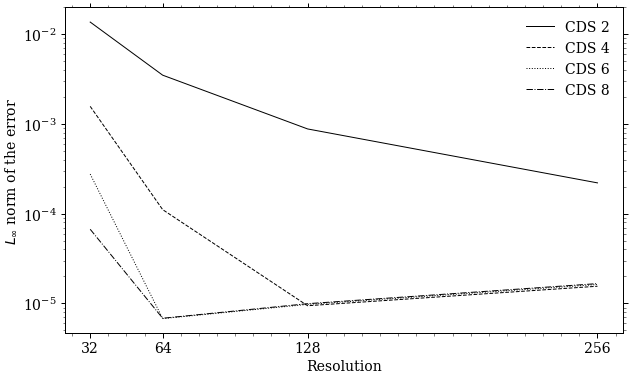

In [9]:
col = ['-', '--', ':', '-.']
for i, order in  enumerate(orders):
    plt.semilogy(resolutions, norm[i,:], label="CDS "+str(order), c='k', linestyle=col[i])
plt.xticks(resolutions)
plt.legend(); plt.xlabel("Resolution"); plt.ylabel(r"$L_{\infty}$ norm of the error")
plt.show()